## What's the point of this notebook?
This notebook has two main goals. 
<br>**First**, it serves as a practical guide to SDXL 1.0 image generation. The code separates key components to make the process more transparent. 
<br>**Second**, it demonstrates how robust SDXL 1.0 is to noise and how different guidance scale values affect image quality.

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline
import numpy as np
import os
import random

In [ ]:
# Seed everything for reproducibility
random_seed = 42
os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

###########################################################################
# Step 1. Initialize pipeline and extract models
###########################################################################

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipeline = StableDiffusionXLPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

tokenizer_1 = pipeline.tokenizer
tokenizer_2 = pipeline.tokenizer_2
text_encoder_1 = pipeline.text_encoder
text_encoder_2 = pipeline.text_encoder_2
scheduler = pipeline.scheduler
unet = pipeline.unet
image_encoder = pipeline.image_encoder
vae = pipeline.vae

images = []
noise_levels = [0.0, 0.25, 0.5, 0.75]
guide_levels = [5, 10, 20, 30, 50]

for noise_level in noise_levels:
    for guide_scale in guide_levels:
        # Seed everything for reproducibility
        random_seed = 42
        os.environ['PYTHONHASHSEED'] = str(random_seed)
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        
        ###########################################################################
        # Step 2: Tokenize a sample prompt
        ###########################################################################
        
        prompt="A serene mountain landscape at sunrise, with snow-capped peaks reflecting in a clear lake, vibrant wildflowers in the foreground, a cozy cabin by tall pines, and a colorful sky blending orange, pink, and purple."
        
        tokens_text_encoder_1 = tokenizer_1(prompt, return_tensors="pt", padding="max_length", max_length=77).input_ids.to("cuda")
        tokens_text_encoder_2 = tokenizer_2(prompt, return_tensors="pt", padding="max_length", max_length=77).input_ids.to("cuda")
        
        ###########################################################################
        # Step 3: Pass tokens through text encoders
        ###########################################################################
        
        with torch.no_grad():
            text_encoder_output_1 = text_encoder_1(tokens_text_encoder_1, output_hidden_states=True)
            pooled_prompt_embeds_1 = text_encoder_output_1[0]
            prompt_embeds_1 = text_encoder_output_1.hidden_states[-2]
            del text_encoder_output_1
            text_encoder_output_2 = text_encoder_2(tokens_text_encoder_2, output_hidden_states=True)
            pooled_prompt_embeds_2 = text_encoder_output_2[0]
            prompt_embeds_2 = text_encoder_output_2.hidden_states[-2]
            del text_encoder_output_2
        
        
        ###########################################################################
        # Step 4: Concatenate embeddings to create prompt_embeds
        ###########################################################################
        
        prompt_embeds = torch.cat([prompt_embeds_1, prompt_embeds_2], dim=-1).to(torch.float16)
        negative_prompt_embeds = torch.zeros_like(prompt_embeds)
        pooled_prompt_embeds = pooled_prompt_embeds_2 # Just to keep the naming convention of the original code for ease of comparison
        prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
        
        # Add noise based on interpolation
        noise = torch.randn_like(prompt_embeds)  # Generate pure noise
        prompt_embeds = (1 - noise_level) * prompt_embeds + noise_level * noise
        
        ###########################################################################
        # Step 5: Conditional image (pseudo-code)
        ###########################################################################
        
        # NOTE: I don't image conditioning, it's only here for completion's sake 
        # conditional_image = pipeline.image_processor("path_to_conditional_image.jpg")
        # conditional_image = image_encoder(conditional_image)
        
        ###########################################################################
        # Step 6: Initialize Latents and Set Up Noise Scheduler
        ###########################################################################
        
        num_inference_steps = 50
        scheduler.set_timesteps(num_inference_steps)
        
        latent_shape = (1, 4, 128, 128) # Image size is control here
        latents = torch.randn(latent_shape, generator=None, device="cuda", dtype=torch.float16, layout=torch.strided).to("cuda")
        latents = latents * scheduler.init_noise_sigma
        
        ###########################################################################
        # Step 7: Denoising Loop with UNet
        ###########################################################################
        
        extra_step_kwargs = {'generator': None}
        add_text_embeds = torch.zeros((2, 1280), dtype=torch.float16).to("cuda")
        add_time_ids = torch.tensor([[1024., 1024., 0., 0., 1024., 1024.]], dtype=torch.float16).to("cuda").repeat(2, 1)
        
        with torch.no_grad():
            for i, t in enumerate(scheduler.timesteps):
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = scheduler.scale_model_input(latent_model_input, t)
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                noise_pred = unet(
                    latent_model_input,
                    t,
                    # image=conditional_image,
                    encoder_hidden_states=prompt_embeds,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guide_scale * (noise_pred_text - noise_pred_uncond)
                latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
        
        ###########################################################################
        # Step 8: Denormalize and Decode Latents to Image with VAE
        ###########################################################################
        
        vae.post_quant_conv.to(vae.dtype)
        vae.decoder.conv_in.to(vae.dtype)
        vae.decoder.mid_block.to(vae.dtype)
        vae.to(dtype=torch.float32)
        latents = latents.to(torch.float32)
        
        # Apply scaling and denormalize if mean and std are defined
        latents = latents / pipeline.vae.config.scaling_factor
        
        # Decode the latents to get the image in pixel space
        with torch.no_grad():
            image = vae.decode(latents, return_dict=False)[0]
        
        # Cast VAE back to float16 if it was upcasted
        vae.to(dtype=torch.float16)
        
        image = pipeline.image_processor.postprocess(image, output_type='pil')[0]
        image = np.asarray(image)
        images.append((guide_scale, noise_level, image))

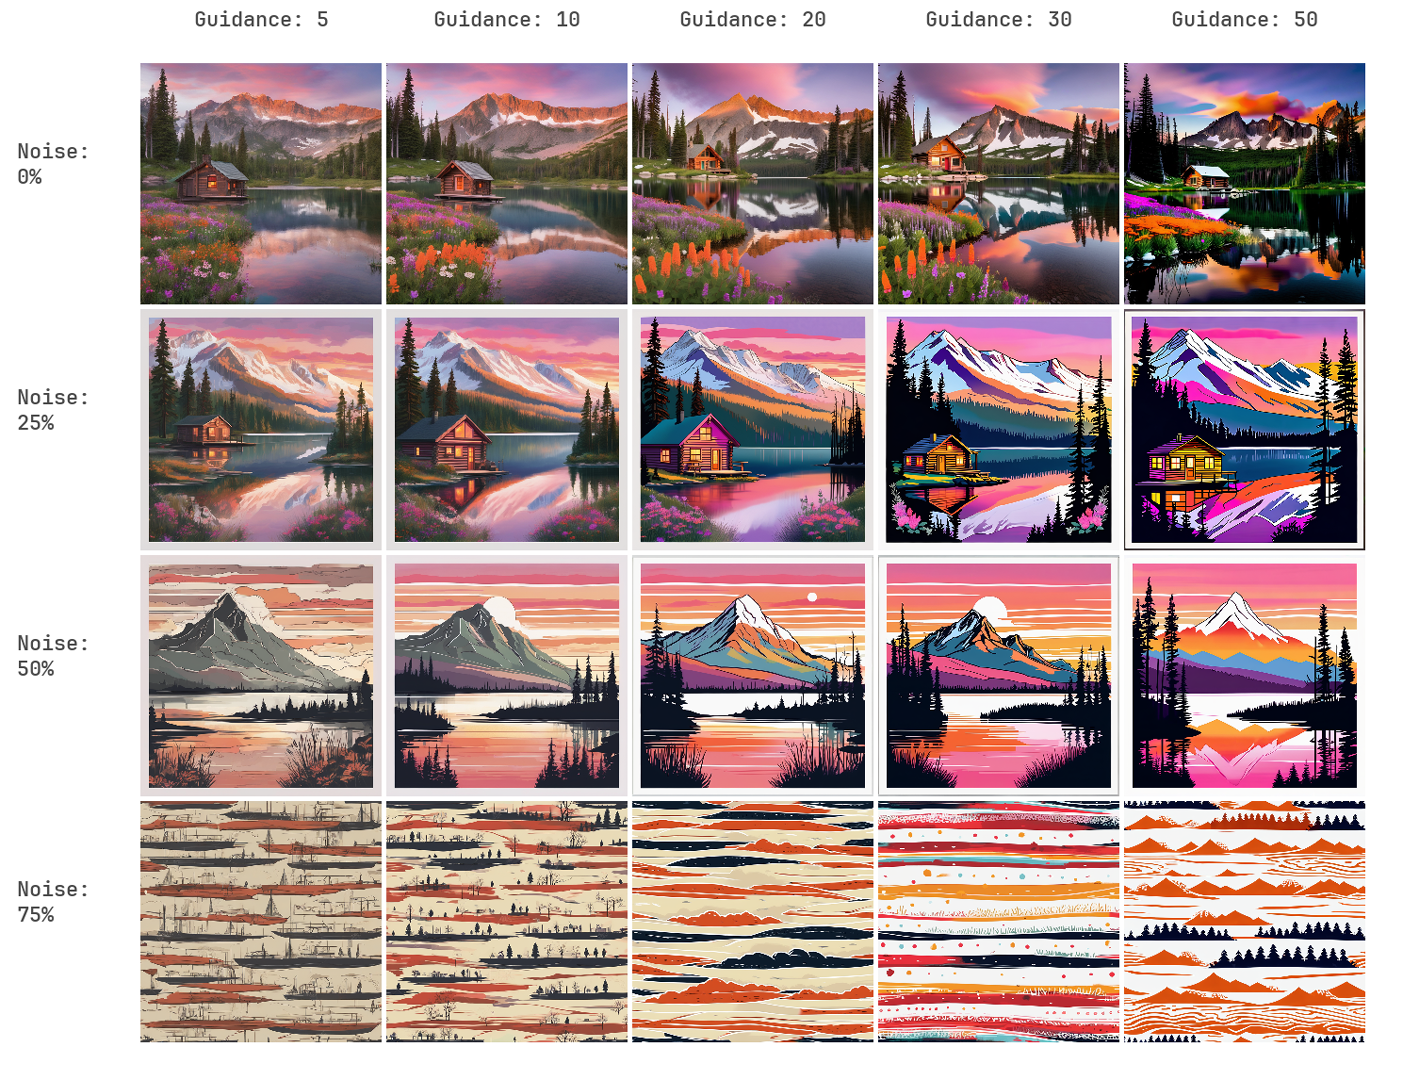

In [4]:
from justshowit import show_grid_configurable
import cv2

show_grid_configurable(
    [s[-1] for s in images],
    save_image_path=r"../dataset/tutorial_data/noise_guidance_exploration.jpg",
    rows=4, cols=5,
    c_image_resizing={"max_width":256, "max_height":256, "min_width":0, "min_height":0, "interpolation":cv2.INTER_CUBIC},
    row_text=["Noise: \n"+str(int(i*100))+"%" for i in noise_levels],
    col_text=["Guidance: "+str(i) for i in guide_levels]
)